# Installing the required packages

In [1]:
!pip install -e .
!pip install spacy
!pip install pandas
!pip install openpyxl
!pip install beautifulsoup4
!pip install sentence_transformers
!pip install bert_score
!pip install python-dotenv
!pip install instructor
!pip install loguru
!pip install nltk
!pip install unstructured
!pip install python-docx 
!pip install exceptions
!pip install pypdf
!pip install langchain
!python3 -m spacy download en_core_web_lg

Obtaining file:///Users/rajashreedahal/Desktop/workshop_demo
ERROR: file:///Users/rajashreedahal/Desktop/workshop_demo does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## Importing necessary modules and packages

In [2]:
import json
import os
import re
import ssl
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import instructor
from loguru import logger
from openai import OpenAI
from pydantic import BaseModel, ValidationError,constr,Field
from typing import Literal
import pandas as pd
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from functools import cache
from typing import Callable, List, Optional, Type
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Download NLTK resources
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
# Load environment variables from .env file
load_dotenv()



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rajashreedahal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajashreedahal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Script prepared for TextProcessing and Metadata Extraction

In [12]:
class TextProcessor(ABC):
    """
    A component for text processing.
    """
    def __init__(self, debug: bool = False) -> None:
        self.debug = debug

    @abstractmethod
    def process(self, text: str, **kwargs) -> str:
        return text

    def __call__(self, *args, **kwargs) -> str:
        return self.process(*args, **kwargs)


class PIIRemover(TextProcessor):
    """
    Rmoves Personal Identifiable Information
    """

    _PATTERN_EMAIL = re.compile(
        "(([\w-]+(?:\.[\w-]+)*)@((?:[\w-]+\.)*\w[\w-]{0,66})\."
        "([a-z]{2,6}(?:\.[a-z]{2})?))(?![^<]*>)",
    )
    _PATTERN_PHONE = re.compile(
        r"((1-\d{3}-\d{3}-\d{4})|(\(\d{3}\) \d{3}-\d{4})|(\d{3}-\d{3}-\d{4}))",
    )

    def __init__(
        self,
        spacy_model: str = "en_core_web_lg",
        debug: bool = False,
    ) -> None:
        super().__init__(debug=debug)
        self.nlp = spacy.load("en_core_web_lg")

    def _process_name(self, text: str) -> str:
        doc = self.nlp(text)
        for entity in doc.ents:
            if (
                entity.label_ == "PERSON"
                and " " in entity.text
                and entity.text.istitle()
            ):  # Extracting Full Names by usig Spacy
                text = text.replace(entity.text, "<NAME>")
        return text
        
    def _process_email(self, text: str) -> str:
        return self._PATTERN_EMAIL.sub("<EMAIL_ID>", text)

    def _process_phone(self, text: str) -> str:
        return self._PATTERN_PHONE.sub("<PHONE_NUMBER>", text)

    def process(self, text: str) -> str:
        text = self._process_name(text)
        text = self._process_email(text)
        text = self._process_phone(text)
        return text


class NonAlphaNumericRemover(TextProcessor):
    """
    Removes non-alpha-numeric characters from the text.
    """

    _alnum_regex = re.compile(r"(?ui)\W")

    def __init__(self, ignore_case: bool = True, debug: bool = False) -> None:
        super().__init__(debug=debug)
        self.ignore_case = bool(ignore_case)

    def process(self, text: str) -> str:
        if self.ignore_case:
            text = text.lower()
        return self._alnum_regex.sub(" ", text).strip()


class TextProcessingPipeline(TextProcessor):
    """
    A container to hold provided text processors and execute serially.
    """

    def __init__(self, *processors, debug: bool = False) -> None:
        super().__init__(debug=debug)
        self.processors = processors

    def process(self, text: str) -> str:
        for processor in self.processors:
            text = processor(text)
        return text



class AbstractMetadataExtractor(ABC):
    """
    Each MetadataExtractor can be used like a functor through __call__.

    Any downstream implementation/subclass should implement `_extract(...)`
    method.

    Args:
        ```preprocessor```: ```Optional[Callable]```
            A callable that preprocessing input text string.
            Defaults to merging multiple whitespace into single.
        ```debug```: ```bool```
            Flag to enable debug mode logs.
            Defaults to `False`
    """

    def __init__(
        self,
        preprocessor: Optional[Callable] = None,
        debug: bool = False,
    ) -> None:
        self.debug = debug
        self.preprocessor = preprocessor or self._preprocess_text
    def extract_metadata(self, text: str) -> Optional[Type[BaseModel]]:
            """
            Extract metadata from the input text
    
            Args:
                ```text```: ```str```
                    Input text from which metadata is extracted
    
            Returns:
                Return a pydantic schema object to map the metadata
            """
            text = self.preprocessor(text)
            return self._extract(text) if text else None
    
    @cache
    @abstractmethod
    def _extract(self, text: str):
        raise NotImplementedError()

    @staticmethod
    def _preprocess_text(text: str):
        text = re.sub(r"\s+", " ", text)
        text = text.strip()
        return text

    def __call__(self, *args, **kwargs):
        return self.extract_metadata(*args, **kwargs)


class SimpleOpenAIMetadataExtractor(AbstractMetadataExtractor):
    """
    Barebone extractor that just hits OpenAI API based on instructor patching.
    No function calling.
    TODO:
        Bugfix nasty side-effects because of instructor patch.
        Calling this 2nd time after we called `InstructorBasedOpenAIMetadataExtractor`
        throws validation error.
    """

    _SYSTEM_PROMPT ="Extract metadata and entities details accurately from my requests." + "Metadata extraction for Indicators should clearly be one of the element in the list ['Disasters','Human Dimensions','Food Availability','Health & Air Quality','Water Availability', 'Extreme Heat','Urban Flooding','Climate Change']. Do not create new element for indicators " + "Geographic_Coverage: If multiple countries, write global, else write name of location"+ "Make sure the following fields follow the following regex pattern"+"Spatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$"+"Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$"+"Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$."

    def __init__(
        self,
        schema: Type[BaseModel],
        model: str = "gpt-3.5-turbo",
        openai_client: Optional[OpenAI] = None,
        api_key: Optional[str] = None,
        system_prompt: str = _SYSTEM_PROMPT,
        preprocessor: Optional[Callable] = None,
        max_retries: int = 1,
        debug: bool = False,) -> None:
        super().__init__(debug=debug, preprocessor=preprocessor)
        self.model = model
        self.schema = schema
        self._system_prompt = system_prompt
        self.max_retries = max_retries
        self.openai_client = openai_client or OpenAI(
            api_key=os.environ.get("OPENAI_API_KEY")
        )

    def _get_messages(self, text: str) -> List[dict]:
        messages = []

        if self._system_prompt:
            messages.append({"role": "system", "content": self._system_prompt})

        messages.append({"role": "user", "content": text})

        return messages

    def _extract(self, text: str):
        text = text.strip()
        client = instructor.patch(
            self.openai_client.copy(),
            mode=instructor.function_calls.Mode.FUNCTIONS,
        )
        messages = self._get_messages(text)
        if self.debug:
            logger.debug(f"messages :: {messages}")
        metadata = client.chat.completions.create(
            model=self.model,
            temperature=0,
            response_model=self.schema,
            max_retries=self.max_retries,
            messages=messages,
        )
        return metadata


class InstructorBasedOpenAIMetadataExtractor(SimpleOpenAIMetadataExtractor):
    """
    This uses `instructor` to hit the OpenAI function calling api.
    Note: The schema for metadata should be of `Type[OpenAISchema]`.
    """
    def _extract(self, text: str):
        schema = instructor.openai_schema(self.schema)
        response = self.openai_client.chat.completions.create(
            model=self.model,
            temperature=0,
            functions=[schema.openai_schema],
            function_call={"name": schema.openai_schema["name"]},
            messages=self._get_messages(text),
        )
        return response

## Creating a schema for Environmental Justice Metadata Extractions and defining the text_processor_pipeline

In [13]:

# Access the API key from the environment
openai_api_key = os.getenv("OPENAI_API_KEY")
text_processor = TextProcessingPipeline(
    lambda x: re.sub(r"\$(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\)(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\#(?=\w|\n|\()", " ", x).strip(),
    lambda x: x.replace("\t", " ").replace("!", " ").strip(),
    PIIRemover()
)

class Environmental_Justice(BaseModel):
    Indicators: Literal["Disasters","Human Dimensions","Food Availability","Health & Air Quality","Water Availability", "Extreme Heat","Urban Flooding","Climate Change"]
    Geographic_Coverage: str
    Format: str
    Spatial_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$')
    Temporal_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$')
    Temporal_Extent: str = Field(pattern=r'^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$')
    
schema = Environmental_Justice


# Metadata Extractions begins from here

## creating directory for extractions

In [8]:
!mkdir extractions
!mkdir extractions/before_finetuning/
!mkdir extractions/after_finetuning/

mkdir: extractions: File exists
mkdir: extractions/before_finetuning/: File exists
mkdir: extractions/after_finetuning/: File exists


## We will start with initial metadata extractions on validation dataset. This means extracting metadata using normal gpt model without finetuning

In [14]:
validation_data=pd.read_csv("EJ_validation_data.csv",encoding='latin1')
final_data={}
# count=0
import requests
for each_data in validation_data.iterrows():
    if "doi" in each_data[1].iloc[11]:
        final_data[each_data[1].iloc[11]]={"Indicators":each_data[1].iloc[1],
                  "Geographic_Coverage":each_data[1].iloc[4],
                  "Format":each_data[1].iloc[5],
                  "Spatial_Resolution":each_data[1].iloc[7],
                  "Temporal_Resolution":each_data[1].iloc[8],
                  "Temporal_Extent":each_data[1].iloc[9]}
url_lists=list(final_data.keys())
url_content=[]
urls=[]
count=0
for url in url_lists:  
    response=requests.get(url)
    html_page = response.text
    soup = BeautifulSoup(html_page, "html.parser")
    text=soup.get_text()
    text=text.lower()
    # Tokenization
    tokens = word_tokenize(text) 
    # Remove punctuation and make lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    text=" ".join(tokens)
    text = re.sub(r'[\t\n\r\f\v]+', '', text)
    text=re.sub(r'[^\w\s]', '', text)
    url_content.append(text)
    urls.append(url.strip())

#using gpt-3.5-turbo-0125 model for initial extractions
metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
    model="gpt-3.5-turbo-0125",
    schema=schema,
    preprocessor=text_processor,
    debug=False,
)
before_finetuning={}
for enum,text in enumerate(url_content):
    split=text.split()
    if len(split)>1900:
        text=" ".join(split[0:1900])
    result = metadata_extractor(text)
    message=result.choices[0].message.function_call.arguments
    metadata=json.loads(message)
    before_finetuning[urls[enum]]=metadata
with open("extractions/before_finetuning/EJ_validation_data3.json",'w') as file:
        json.dump(before_finetuning,file,indent=4)

## Extracting EJ metadata on Finetuned model


In [14]:
metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
    model="ft:gpt-3.5-turbo-0125:nasa::95HlOXEN",
    schema=schema,
    preprocessor=text_processor,
    debug=False,
)
after_finetuning={}
for enum,text in enumerate(url_content):
    split=text.split()
    if len(split)>1900:
        text=" ".join(split[0:1900])
    result = metadata_extractor(text)
    message=result.choices[0].message.function_call.arguments
    metadata=json.loads(message)
    after_finetuning[urls[enum]]=metadata
with open("extractions/after_finetuning/EJ_validation_data2.json",'w') as file:
        json.dump(after_finetuning,file,indent=4)


## Collecting true data in a desirable format

In [15]:
import json
true_data = {}
for i, row in validation_data.iterrows():
    source_link_col = ["Source/Link","Indicators","Geographic Coverage","Format","Spatial Resolution","Spatial Resolution (Standard)","Temporal Resolution","Temporal Extent","Latency"]
    alternate_vals=row[source_link_col]
    alternate_vals=list(alternate_vals)
    alternate_values=alternate_vals[1:]
    value={}
    for enum,i in enumerate(source_link_col[1:]):
            value[i]=alternate_values[enum]
    true_data[alternate_vals[0]]=value


## Script preparation for evaluation

In [16]:

# Evaluation Metric: will be used for indicators field
def evaluate_exact_match(predicted, ground_truth):
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if int(predicted == ground_truth)==1:
        return 1
    else:
        #in case of multiple indicators, if one is correct, then it is true prediction
        predicted_indicators=set(predicted.split(","))
        ground_truth_indicators=set(ground_truth.split(","))
        if predicted_indicators.intersection(ground_truth_indicators):
            return 1
    return 0
                                 

# Evaluation Metric: Exact Match or at least one match if multiple
def evaluate_format(predicted, ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    if type(predicted)==float and type(ground_truth)==float:
        return 1  
    elif type(ground_truth)==float:
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if predicted==ground_truth:
        return 1
    #in case of multiple Formats, if one is correct, then it is true prediction
    predicted_formats = set(predicted.split(","))
    ground_truth_formats = set(ground_truth.split(","))
    if predicted_formats.intersection(ground_truth_formats):
        return 1
    return 0

def evaluate_spatial_resolution(predicted, ground_truth1,ground_truth2):
    predicted = np.nan if predicted=="N/A" else predicted
    if (type(predicted)==float and type(ground_truth1)==float) or (type(predicted)==float and type(ground_truth2)==float) or (type(ground_truth1)==float and type(ground_truth2)==float):
        return 1
    elif (type(ground_truth1)==float or type(ground_truth2)==float):
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth1=ground_truth1.lower()
    ground_truth2=ground_truth2.lower()
    if (predicted==ground_truth1) or (predicted==ground_truth2):
        return 1
    predicted = re.sub(r'[a-zA-Z\(\)\[\]]', '', predicted).strip()
    ground_truth1=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth1).strip()
    ground_truth2=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth2).strip()
    if not (ground_truth1 or ground_truth2) and predicted.find(',') != -1:
        return 1
    ground_truth1=re.sub(r'[^\d.]', '', ground_truth1)
    ground_truth2=re.sub(r'[^\d.]', '', ground_truth2)
    predicted=re.sub(r'[^\d.]', '', predicted)
    if predicted==ground_truth1 or predicted==ground_truth2:
        return 1
    if predicted and ((ground_truth1 and (predicted.replace(" ","")==ground_truth1.replace(" ",""))) or (ground_truth2 and (predicted.replace(" ","")==ground_truth2.replace(" ","")))):
        return 1
    return 0


def evaluate_temporal_resolution_extent(predicted,ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    ground_truth=np.nan if (type(ground_truth)==str and ground_truth.lower()=="nan") else ground_truth
    if type(predicted)==float and type(ground_truth)==float:
        return 1
    if type(ground_truth)==float:
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=str(ground_truth).lower()
    if predicted==ground_truth:
        return 1
    predicted = ''.join(re.findall(r'\w', predicted))
    ground_truth=''.join(re.findall(r'\w', ground_truth))
    if predicted==ground_truth:
        return 1 
    return 0    

# Making sure our true data, before_finetuned extractions, after finetuned extractions have the same source of link

In [17]:
truth_data={}
for i, value in true_data.items():
    if not isinstance(i,float):
        truth_data[i.strip()]=value 
true_data=truth_data
intersection_keys = set(before_finetuning.keys()) & set(after_finetuning.keys()) & set(true_data.keys())
before_finetuned={k:before_finetuning[k] for k in intersection_keys}
after_finetuned={k:after_finetuning[k] for k in intersection_keys}
true_data={k:true_data[k] for k in intersection_keys}


## Defining the extraction performance in boolean field: 0 ==> wrong prediction, 1 ==> correct prediction

In [18]:
def boolean_metrics(true_data,pred_data):
    metrics={}
    for key in true_data.keys():
        reject_key=[np.nan]
        if key not in reject_key:
            true_source=true_data[key]
            try:
                pred_source=pred_data[key]
            except:
                pred_source=pred_data[key.strip()]
            for each_key in pred_source.keys():
                if each_key=="Indicators":
                    result=evaluate_exact_match(pred_source[each_key],true_source[each_key])
                    if result!="ignore":
                        if each_key not in metrics.keys():
                                metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
                elif each_key=="Geographic_Coverage":
                    result=evaluate_format(pred_source[each_key],true_source["Geographic Coverage"])
                    if result!="ignore":
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result) 
                        
                elif each_key=="Format":
                    result=evaluate_format(pred_source[each_key],true_source[each_key])
                    if result!='ignore':
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
                elif each_key=="Spatial_Resolution":
                    result=evaluate_spatial_resolution(pred_source[each_key],true_source["Spatial Resolution"],true_source["Spatial Resolution (Standard)"])
                    if result!='ignore':
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
                elif each_key=="Temporal_Resolution":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Resolution"])
                    if result!='ignore':
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
                elif each_key=="Temporal_Extent":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Extent"])
                    if result!='ignore':
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
                elif each_key=="Latency":
                    result=evaluate_latency(pred_source[each_key],true_source["Latency"])
                    if result!='ignore':
                        if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                        else:
                            metrics[each_key].append(result)
    return metrics

def get_metrics(predictions):
    aspect_metrics = {}
    for aspect, preds in predictions.items():
        accuracy = accuracy_score(preds, [1]*len(preds))  # Assuming ground truth is always 1
        aspect_metrics[aspect] = accuracy
    return aspect_metrics

## Extracting accuracy metrics on boolean evaluation

In [19]:
before_metrics=boolean_metrics(true_data,before_finetuned)
metrics_before_finetuning=get_metrics(before_metrics)

after_metrics=boolean_metrics(true_data,after_finetuned)
metrics_after_finetuning=get_metrics(after_metrics)


## Implementing prompt based gpt evaluation for true and extracted metadata

In [21]:
prompt="""You are given a dictionary of true data and its prediction. Based on the information, give boolean result for each 
feature in the data if its true data and prediction are same or nearly same.\
Evaluation criteria are as follows: 
Indicators: if true data and predicted indicator are same, set 1, if one of the predicted indicator is same, set 1, else set 0
Geographic_Coverage: if same, set 1, elif multiple countries in one and global in another, set 1, if both nan set 1 else 0
Format: if true format and predicted format are same, set 1, elif few samples are similar, set 1, if both nan the set 1 else set 0
Spatial Resolution: if true spatial resolution and predicted spatial resolution are similar or same, set 1, if both are nan set 1 else set 0
Temporal Resolution: if true temporal resolution and predicted temporal resolution are similar or same, set 1, if both are nan set 1 else set 0
Latency: if both true latency and predicted latency are nan or not available or both are same or similar, set 1 else set 0
Output format:
{given url: {"Indicators": 0 or 1,
"Geographic_Coverage": 0 or 1,
"Format": 0 or 1,
"Spatial_Resolution": 0 or 1,
"Temporal_Resolution": 0 or 1,
"Temporal_Extent":0 or 1',
"Latency": 0 or 1,
}}
"""


## Evaluating the prompt based model performance by feeding true data, predictions of before and after finetuning on gpt-3.5-turbo model

In [22]:
import openai
openai.api_key=openai_api_key
# Get the iterators for each dictionary
iter1 = iter(true_data.items())
iter2 = iter(before_finetuned.items())
iter3 = iter(after_finetuned.items())
before_data=[]
after_data=[]
openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
while True:
    # Get the next item from each dictionary
    try:
        true = next(iter1)
        before = next(iter2)
        after = next(iter3)
        response_before = openai_client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(before)+"True data: "+str(true)}])
        before_data.append(response_before)
        
        response_after = openai_client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(after)+"True data: "+str(true)}])
        after_data.append(response_after)
    except StopIteration:
        break

## preprocessing the gpt evaluation in desirable format

In [23]:
gpt_before_metrics={}
for enum, response_before in enumerate(before_data):
    data=response_before.choices[0].message.content
    data=data.replace("'",'"').replace("True","1").replace("False","0").replace(",\n}","}")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    
    gpt_before_metrics[url[0]]=values[0]


gpt_after_metrics={}
for enum, response_after in enumerate(after_data):
    data=response_after.choices[0].message.content
    data=data.replace("'",'"').replace("True","1").replace("False","0").replace(",\n}","}")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    gpt_after_metrics[url[0]]=values[0]



## Dumping gpt evaluation for future reference

In [24]:
with open("gpt_evaluation/gpt_before_metrics3.json",'w') as file:
    json.dump(gpt_before_metrics,file,indent=4)

with open("gpt_evaluation/gpt_after_metrics3.json",'w') as file:
    json.dump(gpt_after_metrics,file,indent=4)

## converting gpt evaluation in desirable format for extracting accuracy

In [25]:
final_gpt_before_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_before_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_before_metrics:
            final_gpt_before_metrics[key] = []
        final_gpt_before_metrics[key].append(value)

# Convert to the desired format
final_gpt_before_metrics = {key: value for key, value in final_gpt_before_metrics.items()}

final_gpt_after_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_after_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_after_metrics:
            final_gpt_after_metrics[key] = []
        final_gpt_after_metrics[key].append(value)

# Convert to the desired format
finals_gpt_after_metrics = {key: value for key, value in final_gpt_after_metrics.items()}

finals_gpt_before_metrics=get_metrics(final_gpt_before_metrics)
finals_gpt_after_metrics=get_metrics(final_gpt_after_metrics)


## Comparing the performance of model before and after finetuning using defined evaluation metrics

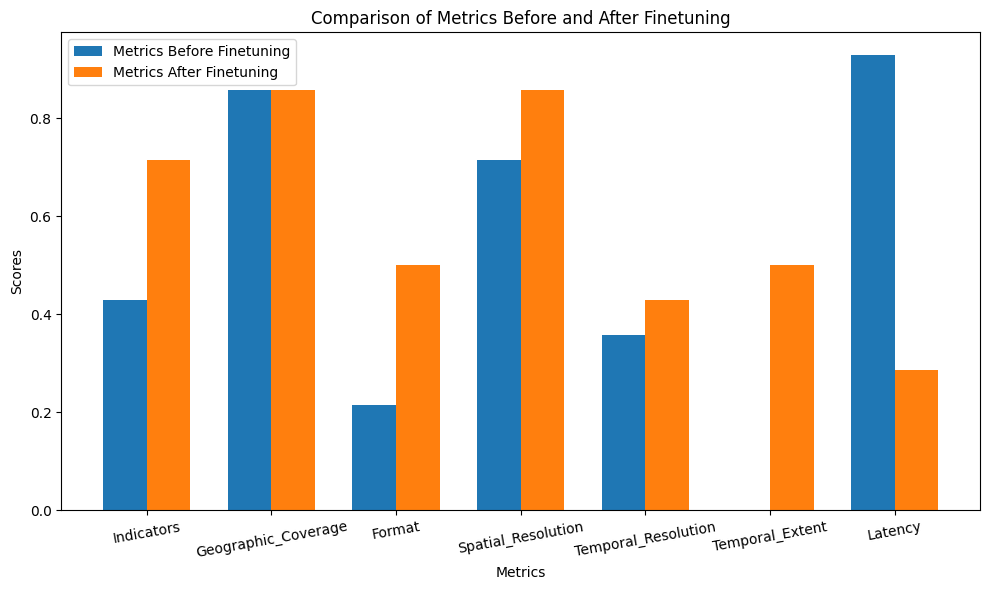

In [26]:
import matplotlib.pyplot as plt
keys = list(finals_gpt_before_metrics.keys())
gpt_before_values = list(finals_gpt_before_metrics.values())
gpt_after_values = list(finals_gpt_after_metrics.values())
metrics_before_values = list(metrics_before_finetuning.values())
metrics_after_values = list(metrics_after_finetuning.values())

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bar graphs
bar_width = 0.35
x = range(len(keys))  # X-axis positions for bars
plt.bar(x, metrics_before_values, width=bar_width, label='Metrics Before Finetuning')
plt.bar([pos + bar_width for pos in x], metrics_after_values, width=bar_width, label='Metrics After Finetuning')

plt.title('Comparison of Metrics Before and After Finetuning')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([pos + bar_width/2 for pos in x], keys, rotation=10)  # Setting keys as x-axis labels

plt.legend()
plt.grid(False)
plt.tight_layout()

## Converting the ground_truth and before and after finetuning extractions in the desirable excel format for human level evaluation

In [27]:
urls=list(true_data.keys())
columns=["Indicators","Indicators_before","Indicators_after","H_Indicator_before","H_Indicator_after",
         "Geographic Coverage","Geographic_Coverage_before","Geographic_Coverage_after","H_Geographic_Coverage_before","H_Geographic_Coverage_after",
         "Format","Format_before","Format_after","H_Format_before","H_Format_after",
         "Spatial Resolution","Spatial Resolution (Standard)","Spatial_Resolution_before","Spatial_Resolution_after","H_Spatial_Resolution_before","H_Spatial_Resolution_after",
         "Temporal Resolution","Temporal_Resolution_before","Temporal_Resolution_after","H_Temporal_Resolution_before","H_Temporal_Resolution_after",
         "Temporal Extent","Temporal_Extent_before","Temporal_Extent_after","H_Temporal_Extent_before","H_Temporal_Extent_after",
         "Latency","Latency_before","Latency_after","H_Latency_before","H_Latency_after"]
human_evaluation=pd.DataFrame(columns=columns)
for each_url in urls:
    tru={"urls":each_url}
    true_details=true_data[each_url]
    tru.update(true_details)
    before_details=before_finetuned[each_url]
    before_details={i+str("_before"):v for i,v in before_details.items()}
    tru.update(before_details)
    after_details=after_finetuned[each_url]
    after_details={i+str("_after"):v for i,v in after_details.items()}
    tru.update(after_details)
    new_data = pd.DataFrame([tru])
    human_evaluation = pd.concat([human_evaluation, new_data], ignore_index=True)

# Dumping the excel sheet and human manually evaluates it

In [28]:
human_evaluation.to_csv("human_evaluation2.5.csv",index=False)

# Loading updated human evaluation : Note: H_Indicator_before means Human evaluation of the field Indicator for before finetuing, similarly, H_Indicator_after means human evaluation of the field Indicator for after finetuning

In [151]:
after_human_evaluation=pd.read_csv("human_evaluation3.csv")
before_columns=['H_Indicator_before',"H_Geographic_Coverage_before",'H_Format_before','H_Spatial_Resolution_before',
         'H_Temporal_Resolution_before','H_Temporal_Extent_before',
         'H_Latency_before']
after_columns=['H_Indicator_after',"H_Geographic_Coverage_after",'H_Format_after','H_Spatial_Resolution_after','H_Temporal_Resolution_after',
              'H_Temporal_Extent_after','H_Latency_after']
human_eval_before=after_human_evaluation[before_columns]
human_eval_after=after_human_evaluation[after_columns]


# Loading the human evaluation

In [152]:
human_eval_before

,H_Indicator_before,H_Geographic_Coverage_before,H_Format_before,H_Spatial_Resolution_before,H_Temporal_Resolution_before,H_Temporal_Extent_before,H_Latency_before
0,1,1,0,1,1,0,0
1,0,1,1,0,1,0,1
2,1,1,1,0,0,0,0
3,1,1,1,1,1,0,1
4,0,1,0,0,0,0,1
5,0,1,0,0,0,0,0
6,0,1,1,1,1,0,1
7,1,0,1,1,0,0,1
8,0,1,0,1,1,0,0
9,1,1,0,0,1,0,1


# Preprocessing the human evaluation in a desirable format for visualization

In [156]:
before=human_eval_before.to_dict(orient='list')
before={i.replace("H_","").replace("_before",""):j for i,j in before.items()}

after=human_eval_after.to_dict(orient='list')
after={i.replace("H_","").replace("_after",""):j for i,j in after.items()}

human_before_metrics=get_metrics(before)
human_after_metrics=get_metrics(after)

keys = list(human_before_metrics.keys())
metrics_before_values = list(human_before_metrics.values())
metrics_after_values = list(human_after_metrics.values())

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bar graphs
bar_width = 0.35
x = range(len(keys))  # X-axis positions for bars
plt.bar(x, metrics_before_values, width=bar_width, label='Human Evaluation of Features Before Finetuning')
plt.bar([pos + bar_width for pos in x], metrics_after_values, width=bar_width, label='Human Evaluation of Features After Finetuning')

plt.title('Comparison of Human Evaluated Metrics Before and After Finetuning')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([pos + bar_width/2 for pos in x], keys, rotation=10)  # Setting keys as x-axis labels

plt.legend()
plt.grid(False)
plt.tight_layout()

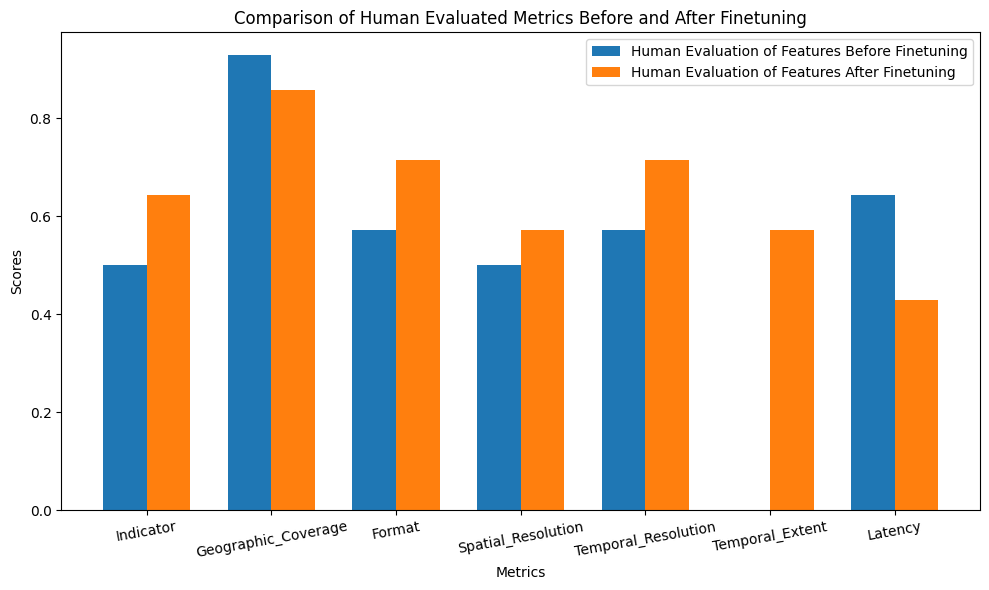